# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

## Importação de Pacotes e Base de Dados

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer



from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from pycaret.classification import *

%matplotlib inline

In [5]:
# Salva a base de dados em 'df'
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [7]:
# Verifica as datas nas quais foram obtidos os dados
df['data_ref'].value_counts()

data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64

In [8]:
# Separa os 3 últimos meses (ano de 2016) como validacao oot, removendo o 'index'
oot = df[df.data_ref.dt.year == 2016].drop(columns = 'index')

# Separa os meses restantes (ano de 2015) como base de desenvolvimento, removendo o 'index'
desenvolvimento = df[df.data_ref.dt.year == 2015].drop(columns = 'index')

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [10]:
# Número de linhas e colunas na base de desenvolvimento
print('Número de linhas: {0} \nNúmero de colunas: {1}'.format(desenvolvimento.shape[0], desenvolvimento.shape[1]))

Número de linhas: 600000 
Número de colunas: 14


In [11]:
# Número de linhas para cada mês
desenvolvimento.data_ref.dt.month.value_counts()

data_ref
1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
10    50000
11    50000
12    50000
Name: count, dtype: int64

### Descritiva Básica Univariada das Variáveis Quantitativas
> As variáveis quantitativas da base de desenvolvimento são: 'idade', 'tempo_emprego' e 'renda'. Fazendo a análise descritiva delas:

In [13]:
# Lista com as variaveis quantitativas
quantitativas = ['idade','tempo_emprego','renda']

# Retorna a análise destas variáveis (média, mediana, contagem, etc)
desenvolvimento[quantitativas].describe()

,idade,tempo_emprego,renda
count,600000.000000,499125.000000,6.000000e+05
mean,43.798530,7.747992,2.722284e+04
std,11.230659,6.688576,8.737788e+04
min,22.000000,0.117808,1.618600e+02
25%,34.000000,3.049315,4.670600e+03
50%,43.000000,6.046575,9.887580e+03
75%,53.000000,10.180822,2.162887e+04
max,68.000000,42.906849,4.083986e+06


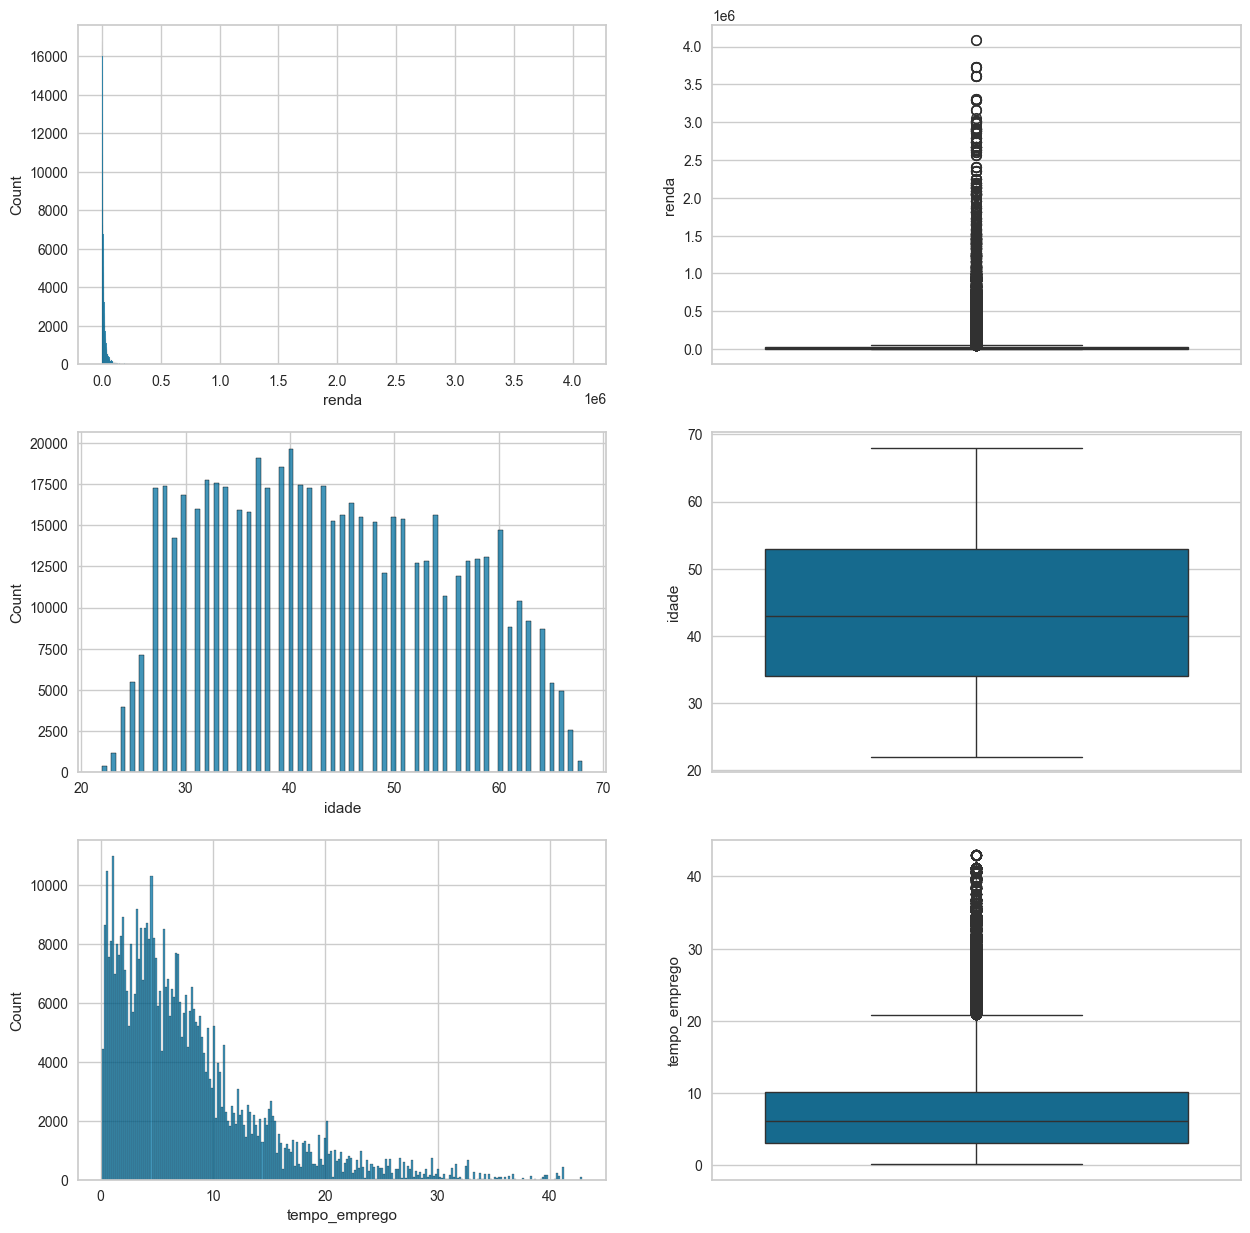

In [14]:
# Gráfico boxplot e contagem de cada variável quantitativa
plt.rc('figure', figsize=(15, 15))
fig, axes = plt.subplots(3, 2)

# 'renda'
sns.histplot(x='renda', data=desenvolvimento, ax = axes[0,0])
sns.boxplot(y='renda', data=desenvolvimento, ax = axes[0,1])

# 'idade'
sns.histplot(x='idade', data=desenvolvimento, ax = axes[1,0])
sns.boxplot(y='idade', data=desenvolvimento, ax = axes[1,1])

# 'tempo_emprego'
sns.histplot(x='tempo_emprego', data=desenvolvimento, ax = axes[2,0])
sns.boxplot(y='tempo_emprego', data=desenvolvimento, ax = axes[2,1])

# Mostra o gráfico
plt.show()

### Descritiva Básica Univariada das Variáveis Qualitativas
> São variáveis qualitativas todas as restantes, ou seja: 'sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'qt_pessoas_residencia' e 'mau'.
>
> Fazendo a análise descritiva univariada de cada uma:

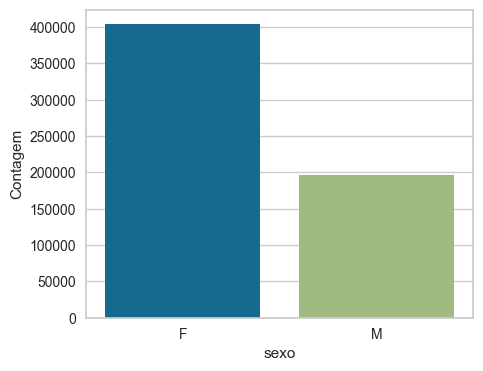

sexo
F    403805
M    196195
Name: count, dtype: int64

In [16]:
# Gráfico de barras da variável 'sexo'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='sexo', data=desenvolvimento, hue='sexo')
plt.ylabel('Contagem')
plt.show()

# Mostra as quantidades de indivíduos de cada sexo
desenvolvimento.sexo.value_counts()

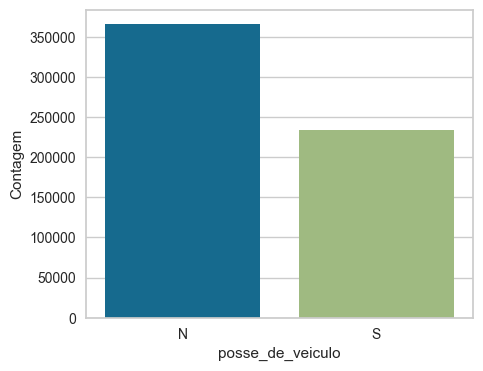

posse_de_veiculo
N    366293
S    233707
Name: count, dtype: int64

In [17]:
# Gráfico de barras da variável 'posse_de_veiculo'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='posse_de_veiculo', data=desenvolvimento, hue='posse_de_veiculo')
plt.ylabel('Contagem')
plt.show()

# Mostra as quantidades de pessoas com veículo
desenvolvimento.posse_de_veiculo.value_counts()

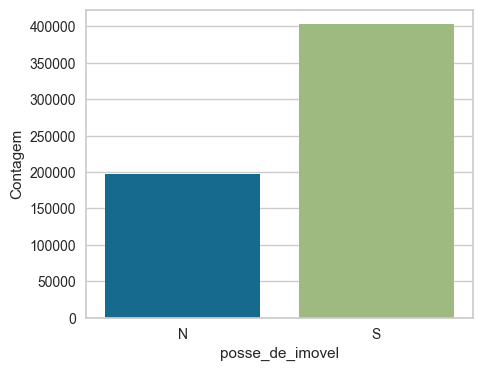

posse_de_imovel
S    403054
N    196946
Name: count, dtype: int64

In [18]:
# Gráfico de barras da variável 'posse_de_imovel'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='posse_de_imovel', data=desenvolvimento, hue='posse_de_imovel')
plt.ylabel('Contagem')
plt.show()

# Mostra as quantidades de pessoas com imóvel
desenvolvimento.posse_de_imovel.value_counts()

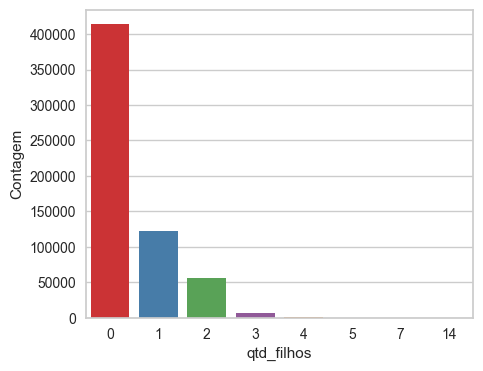

qtd_filhos
0     413882
1     122471
2      55603
3       6960
4        854
7         82
5         77
14        71
Name: count, dtype: int64

In [19]:
# Gráfico de barras da variável 'qtd_filhos'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='qtd_filhos', data=desenvolvimento, hue='qtd_filhos', 
              palette='Set1', legend=False)
plt.ylabel('Contagem')
plt.show()

# Mostra as contagens da quantidade de filhos
desenvolvimento.qtd_filhos.value_counts()

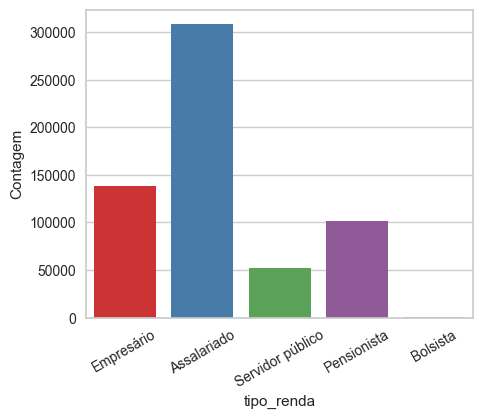

tipo_renda
Assalariado         308460
Empresário          138141
Pensionista         101127
Servidor público     51981
Bolsista               291
Name: count, dtype: int64

In [20]:
# Gráfico de barras da variável 'tipo_renda'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='tipo_renda', data=desenvolvimento, hue='tipo_renda', 
              palette='Set1', legend=False)
plt.ylabel('Contagem')
plt.tick_params(axis='x', rotation=30)
plt.show()

# Mostra as contagens do tipo de renda
desenvolvimento.tipo_renda.value_counts()

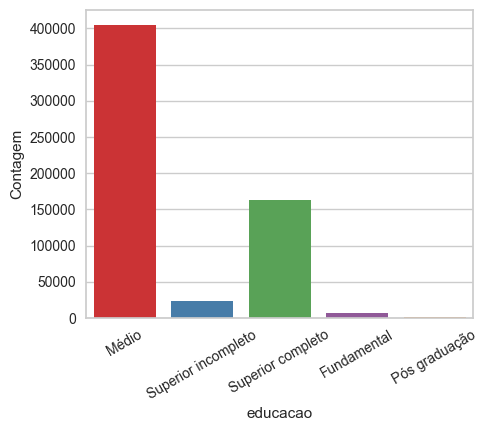

educacao
Médio                  405449
Superior completo      163440
Superior incompleto     23559
Fundamental              6901
Pós graduação             651
Name: count, dtype: int64

In [21]:
# Gráfico de barras da variável 'educacao'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='educacao', data=desenvolvimento, hue='educacao', 
              palette='Set1', legend=False)
plt.ylabel('Contagem')
plt.tick_params(axis='x', rotation=30)
plt.show()

# Mostra as contagens do nível educacional
desenvolvimento.educacao.value_counts()

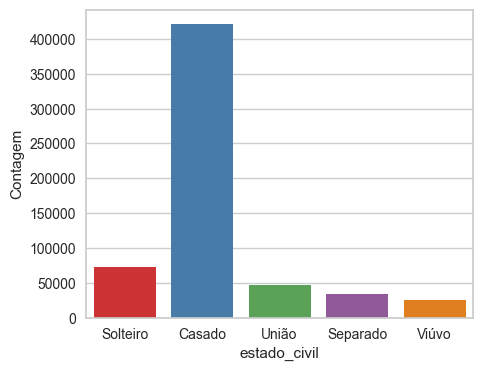

estado_civil
Casado      421149
Solteiro     73221
União        46108
Separado     34188
Viúvo        25334
Name: count, dtype: int64

In [22]:
# Gráfico de barras da variável 'estado_civil'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='estado_civil', data=desenvolvimento, hue='estado_civil', 
              palette='Set1', legend=False)
plt.ylabel('Contagem')
plt.show()

# Mostra as contagens do estado civil
desenvolvimento.estado_civil.value_counts()

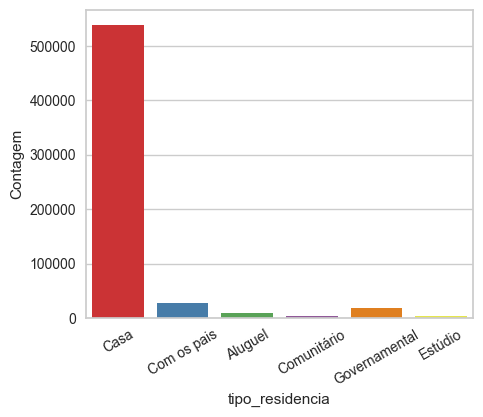

tipo_residencia
Casa             539336
Com os pais       26730
Governamental     18742
Aluguel            8262
Estúdio            4296
Comunitário        2634
Name: count, dtype: int64

In [23]:
# Gráfico de barras da variável 'tipo_residencia'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='tipo_residencia', data=desenvolvimento, hue='tipo_residencia', 
              palette='Set1', legend=False)
plt.tick_params(axis='x', rotation=30)
plt.ylabel('Contagem')
plt.show()

# Mostra a contagem dos tipos de residencia
desenvolvimento.tipo_residencia.value_counts()

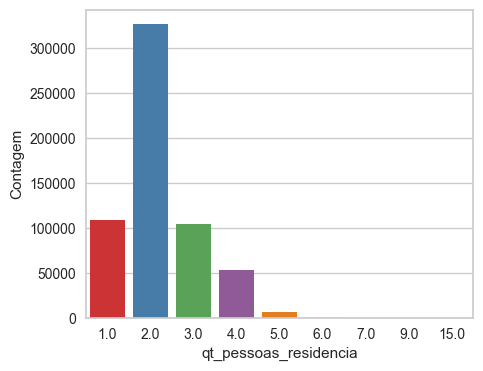

qt_pessoas_residencia
2.0     326181
1.0     108657
3.0     104126
4.0      53314
5.0       6638
6.0        890
9.0         82
15.0        71
7.0         41
Name: count, dtype: int64

In [24]:
# Gráfico de barras da variável 'qt_pessoas_residencia'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='qt_pessoas_residencia', data=desenvolvimento, 
              hue='qt_pessoas_residencia', palette='Set1', legend=False)
plt.ylabel('Contagem')
plt.show()

# Mostra a contagem da quantidade de pessoas por residencia
desenvolvimento.qt_pessoas_residencia.value_counts()

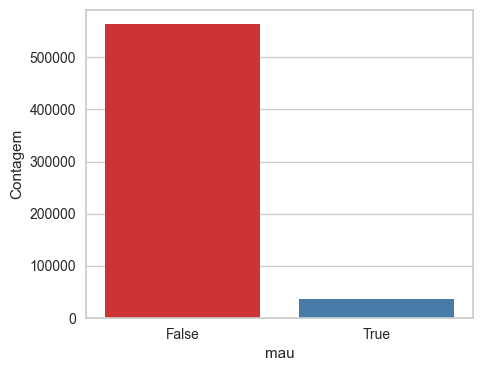

mau
False    563357
True      36643
Name: count, dtype: int64

In [25]:
# Gráfico de barras da variável 'mau'
plt.rc('figure', figsize=(5, 4))
sns.countplot(x='mau', data=desenvolvimento, 
              hue='mau', palette='Set1', legend=False)
plt.ylabel('Contagem')
plt.show()

# Mostra a contagem de devedores
desenvolvimento.mau.value_counts()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

> A análise descritiva bivariada consiste no cálculo do _Informartion Value_ e gráfico de WOE de cada variável. No caso das variáveis contínuas, elas são divididas em 5 grupos antes do cálculo do IV.
>
> Para realizar estas etapas, serão utilizadas as funções **IV**, **biv_discreta** e **biv_continua** desenvolvidas em aula.

In [28]:
# Função que calcula o IV da variável selecionada desenvolvido em aula:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [29]:
# Função que imprime o gráfico WOE para cada categoria da variável discreta
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.plot(biv[var], biv.woe, ':bo', label='woe')
    ax.plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax.plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax.set_xlim([-.3, num_cat-.7])

    ax.set_ylabel("Weight of Evidence")
    ax.legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax.set_xticks(list(range(num_cat)))
    ax.set_xticklabels(biv[var], rotation=30)

    return biv

In [30]:
# Função que imprime o WOE de cada grupo da variável contínua
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    
    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(1,1, figsize=(6,4))
    ax.plot(biv[var], biv.woe, ':bo', label='woe')
    ax.plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax.plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax.set_ylabel("Weight of Evidence")
    ax.legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    return None

### Tabela de metadados com o _IV_ de cada variável explicativa:

In [32]:
# Cria a tabela 'metadados'
metadados = pd.DataFrame(desenvolvimento.drop('data_ref', axis=1).dtypes, 
                         columns=['dtype'])
metadados['nmissing'] = desenvolvimento.isna().sum()
metadados['valores_unicos'] = desenvolvimento.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'

# Calcula o IV de cada variável explicativa
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>5) and (metadados.loc[var, 'dtype']!='object'):
        metadados.loc[var, 'IV'] = IV(pd.qcut(desenvolvimento[var],5,duplicates='drop'), 
                                      desenvolvimento.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(desenvolvimento[var], desenvolvimento.mau)

# Mostra a tabela resultante    
metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0,2,covariavel,0.002665
posse_de_veiculo,object,0,2,covariavel,0.000075
posse_de_imovel,object,0,2,covariavel,0.009690
qtd_filhos,int64,0,8,covariavel,0.000055
tipo_renda,object,0,5,covariavel,0.009718
educacao,object,0,5,covariavel,0.003690
estado_civil,object,0,5,covariavel,0.001305
tipo_residencia,object,0,6,covariavel,0.003330
idade,int64,0,47,covariavel,0.018434
tempo_emprego,float64,100875,3004,covariavel,0.360581


### WOE das variáveis discretas

,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,378318,25487,0.063117,F,403805,0.000383,0.063867,0.062367,-2.697567,-2.684953,-2.710321,0.035125,0.047739,0.02237
M,185039,11156,0.056862,M,196195,0.000523,0.057887,0.055837,-2.808589,-2.789641,-2.827861,-0.075898,-0.056950,-0.09517


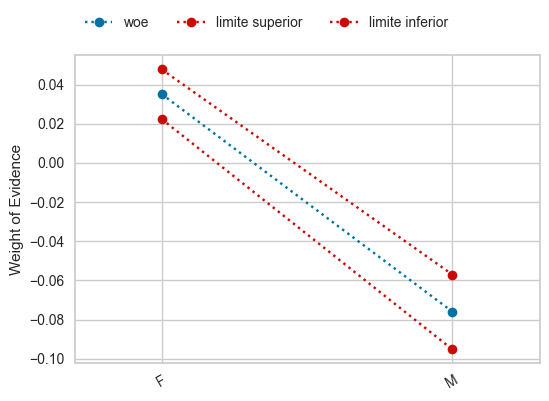

In [34]:
# WOE da variável 'sexo'
biv_discreta('sexo', desenvolvimento)

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,343778,22515,0.061467,N,366293,0.000397,0.062245,0.060689,-2.725814,-2.712410,-2.739378,0.006877,0.020281,-0.006687
S,219579,14128,0.060452,S,233707,0.000493,0.061418,0.059486,-2.743553,-2.726667,-2.760694,-0.010862,0.006024,-0.028003


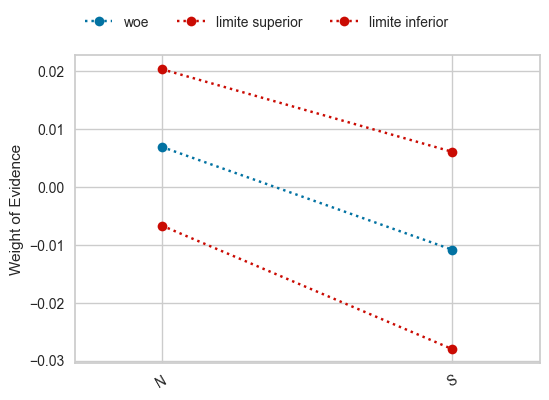

In [35]:
# WOE da variável 'posse_de_veiculo'
biv_discreta('posse_de_veiculo', desenvolvimento)

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,183305,13641,0.069263,N,196946,0.000572,0.070384,0.068141,-2.598071,-2.580806,-2.615598,0.134620,0.151885,0.117093
S,380052,23002,0.057069,S,403054,0.000365,0.057785,0.056353,-2.804727,-2.791496,-2.818114,-0.072036,-0.058805,-0.085423


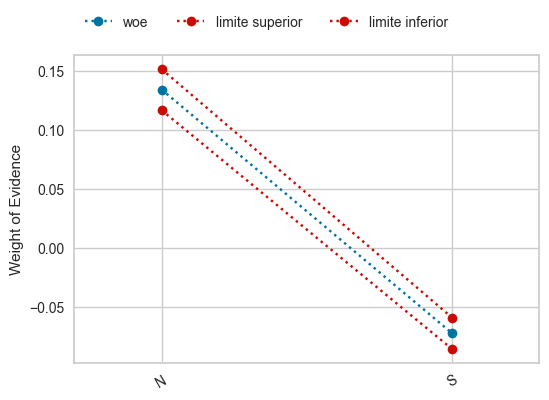

In [36]:
# WOE da variável 'posse_de_imovel'
biv_discreta('posse_de_imovel', desenvolvimento)

,qt_bom,qt_mau,mau,qtd_filhos,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qtd_filhos,,,,,,,,,,,,,,
0,389129,24753,0.059807,0,413882,0.000369,0.060529,0.059084,-2.754964,-2.742189,-2.767885,-0.022273,-0.009497,-0.035194
1,114547,7924,0.064701,1,122471,0.000703,0.066079,0.063323,-2.671089,-2.648545,-2.694085,0.061602,0.084147,0.038606
2,52182,3421,0.061525,2,55603,0.001019,0.063523,0.059528,-2.724805,-2.690727,-2.759933,0.007886,0.041964,-0.027241
3,6493,467,0.067098,3,6960,0.002999,0.072977,0.061219,-2.632151,-2.541841,-2.730127,0.100540,0.190850,0.002564
4,806,48,0.056206,4,854,0.007881,0.071675,0.040737,-2.820883,-2.561236,-3.159030,-0.088192,0.171455,-0.426339
5,67,10,0.129870,5,77,0.038309,0.206169,0.053571,-1.902108,-1.348173,-2.871687,0.830584,1.384518,-0.138996
7,69,13,0.158537,7,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
14,64,7,0.098592,14,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.519718,1.141054,-0.813381


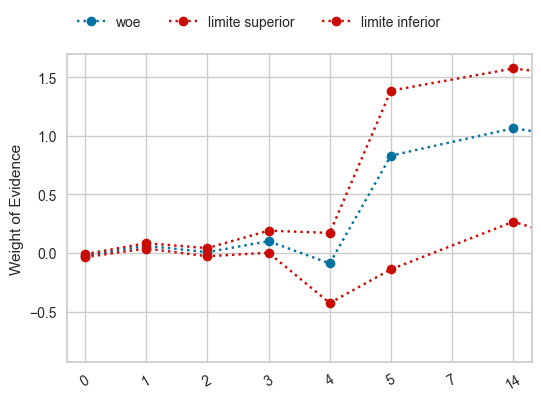

In [37]:
# WOE da variável 'qtd_filhos'
biv_discreta('qtd_filhos', desenvolvimento)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.413614,0.052933,-1.249925
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor público,49651,2330,0.044824,Servidor público,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.326459,-0.285678,-0.368813


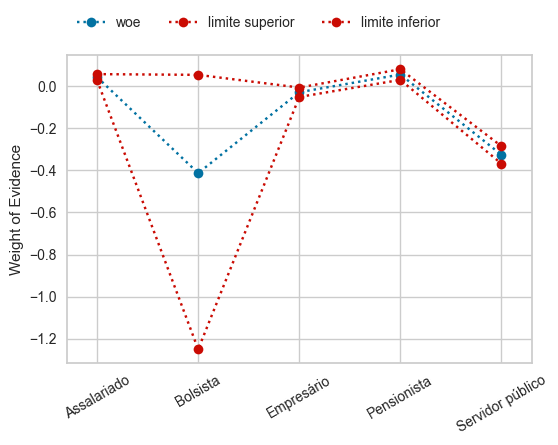

In [38]:
# WOE da variável 'tipo_renda'
biv_discreta('tipo_renda', desenvolvimento)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,6420,481,0.069700,Fundamental,6901,0.003065,0.075709,0.063691,-2.591306,-2.502130,-2.687900,0.141385,0.230561,0.044791
Médio,379939,25510,0.062918,Médio,405449,0.000381,0.063665,0.062170,-2.700940,-2.688333,-2.713688,0.031751,0.044358,0.019003
Pós graduação,608,43,0.066052,Pós graduação,651,0.009735,0.085167,0.046937,-2.648975,-2.374126,-3.010867,0.083716,0.358565,-0.278176
Superior completo,154354,9086,0.055592,Superior completo,163440,0.000567,0.056703,0.054481,-2.832514,-2.811552,-2.853874,-0.099823,-0.078861,-0.121183
Superior incompleto,22036,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550


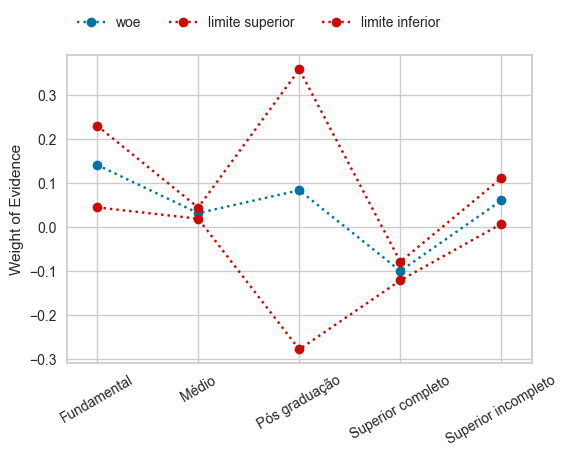

In [39]:
# WOE da variável 'educacao'
biv_discreta('educacao', desenvolvimento)

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,395880,25269,0.060000,Casado,421149,0.000366,0.060717,0.059283,-2.751533,-2.738886,-2.764322,-0.018842,-0.006195,-0.031631
Separado,31994,2194,0.064175,Separado,34188,0.001325,0.066772,0.061577,-2.679822,-2.637360,-2.723916,0.052869,0.095331,0.008775
Solteiro,68585,4636,0.063315,Solteiro,73221,0.000900,0.065079,0.061551,-2.694222,-2.664858,-2.724359,0.038469,0.067833,0.008332
União,43048,3060,0.066366,União,46108,0.001159,0.068638,0.064094,-2.643901,-2.607801,-2.681168,0.088790,0.124890,0.051523
Viúvo,23850,1484,0.058577,Viúvo,25334,0.001475,0.061469,0.055686,-2.777043,-2.725779,-2.830738,-0.044352,0.006912,-0.098047


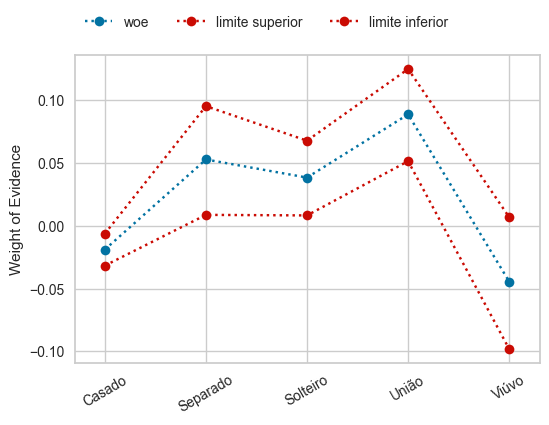

In [40]:
# WOE da variável 'estado_civil'
biv_discreta('estado_civil', desenvolvimento)

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7666,596,0.072137,Aluguel,8262,0.002846,0.077717,0.066558,-2.554310,-2.473779,-2.640804,0.178382,0.258912,0.091887
Casa,506887,32449,0.060165,Casa,539336,0.000324,0.060799,0.059530,-2.748618,-2.737450,-2.759898,-0.015927,-0.004759,-0.027207
Com os pais,24733,1997,0.074710,Com os pais,26730,0.001608,0.077862,0.071558,-2.516492,-2.471755,-2.563000,0.216199,0.260936,0.169691
Comunitário,2449,185,0.070235,Comunitário,2634,0.004979,0.079999,0.060472,-2.583079,-2.442363,-2.743199,0.149612,0.290329,-0.010508
Estúdio,4071,225,0.052374,Estúdio,4296,0.003399,0.059038,0.045711,-2.895544,-2.768721,-3.038637,-0.162852,-0.036030,-0.305946
Governamental,17551,1191,0.063547,Governamental,18742,0.001782,0.067040,0.060054,-2.690318,-2.633076,-2.750571,0.042373,0.099615,-0.017880


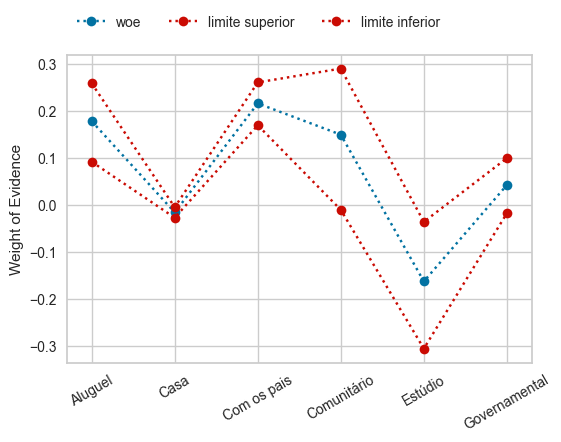

In [41]:
# WOE da variável 'tipo_residencia'
biv_discreta('tipo_residencia', desenvolvimento)

,qt_bom,qt_mau,mau,qt_pessoas_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
qt_pessoas_residencia,,,,,,,,,,,,,,
1.0,101834,6823,0.062794,1.0,108657,0.000736,0.064236,0.061351,-2.703045,-2.678793,-2.727822,0.029646,0.053898,0.004869
2.0,306954,19227,0.058946,2.0,326181,0.000412,0.059754,0.058138,-2.770382,-2.755904,-2.785048,-0.037691,-0.023213,-0.052357
3.0,97323,6803,0.065334,3.0,104126,0.000766,0.066835,0.063833,-2.660672,-2.636351,-2.685518,0.072019,0.096340,0.047173
4.0,50051,3263,0.061203,4.0,53314,0.001038,0.063238,0.059169,-2.730395,-2.695521,-2.766371,0.002296,0.037170,-0.033680
5.0,6189,449,0.067641,5.0,6638,0.003082,0.073683,0.061599,-2.623506,-2.531442,-2.723540,0.109185,0.201250,0.009151
6.0,832,58,0.065169,6.0,890,0.008274,0.081406,0.048931,-2.663389,-2.423389,-2.967184,0.069302,0.309302,-0.234493
7.0,41,0,0.000000,7.0,41,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
9.0,69,13,0.158537,9.0,82,0.040334,0.238789,0.078284,-1.669157,-1.159328,-2.465897,1.063534,1.573363,0.266795
15.0,64,7,0.098592,15.0,71,0.035379,0.169154,0.028029,-2.212973,-1.591637,-3.546072,0.519718,1.141054,-0.813381


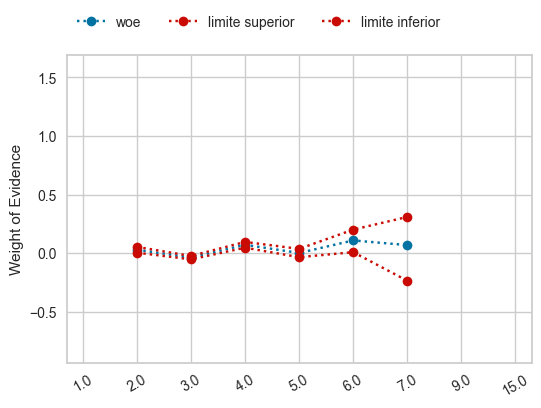

In [42]:
# WOE da variável 'qt_pessoas_residencia'
biv_discreta('qt_pessoas_residencia', desenvolvimento)

### WOE das Variáveis Contínuas

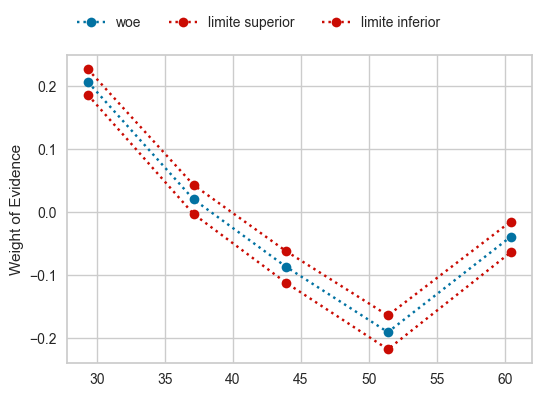

In [44]:
# WOE da variável 'idade'
biv_continua('idade', 5, desenvolvimento)

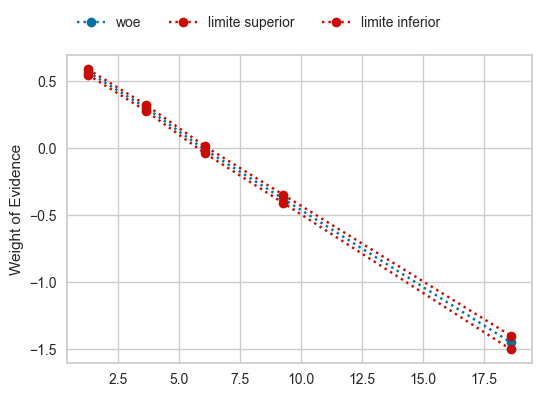

In [45]:
# WOE da variável 'tempo_emprego'
biv_continua('tempo_emprego', 5, desenvolvimento)

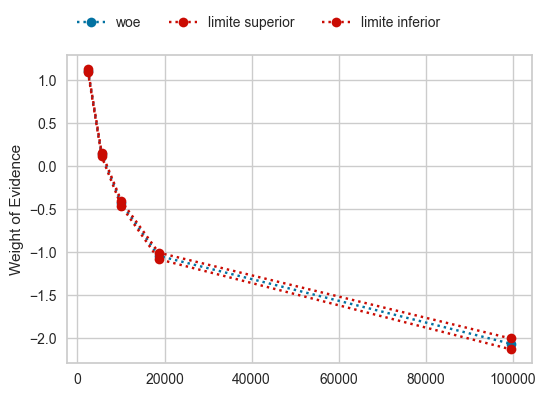

In [46]:
# WOE da variável 'renda'
biv_continua('renda', 5, desenvolvimento)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

### Tratamento de missings e outliers

> A descritiva básica univariada mostrou que há uma grande quantidade de variáveis outliers nas variáveis 'renda' e 'tempo_emprego', sendo que, no primeiro caso, correspondem aos valores superiores a aproximadamente 30000; enquanto que no segundo caso, é o tempo superior a aproximadamente 20 anos. Em vista disso, vamos remover todos estes outliers.
>
> Além disso, a única variável que apresentou valores missings foi a 'tempo_emprego'. Para resolver isso, serão preenchidos com a média da variável.

In [49]:
media_te = desenvolvimento.tempo_emprego.mean()
media_te

7.747992318063461

In [50]:
# Preenche os valores missings da variável 'tempo_emprego'
desenvolvimento.tempo_emprego = desenvolvimento.tempo_emprego.fillna(value=media_te)

# Remove os outliers das variáveis 'renda' e 'tempo_emprego'
desenvolvimento = desenvolvimento[(desenvolvimento['renda'] < 30000) & 
                                  (desenvolvimento['tempo_emprego'] < 21)]

> Analisando graficamente como ficaram as distribuições univariadas das variáveis quantitativas:

               idade  tempo_emprego          renda
count  492185.000000  492185.000000  492185.000000
mean       43.302957       6.070890    9674.610777
std        11.545049       3.749025    7138.581016
min        22.000000       0.117808     161.860000
25%        33.000000       3.101370    3980.340000
50%        42.000000       6.320548    7659.290000
75%        53.000000       7.747992   13799.950000
max        68.000000      20.931507   29999.880000


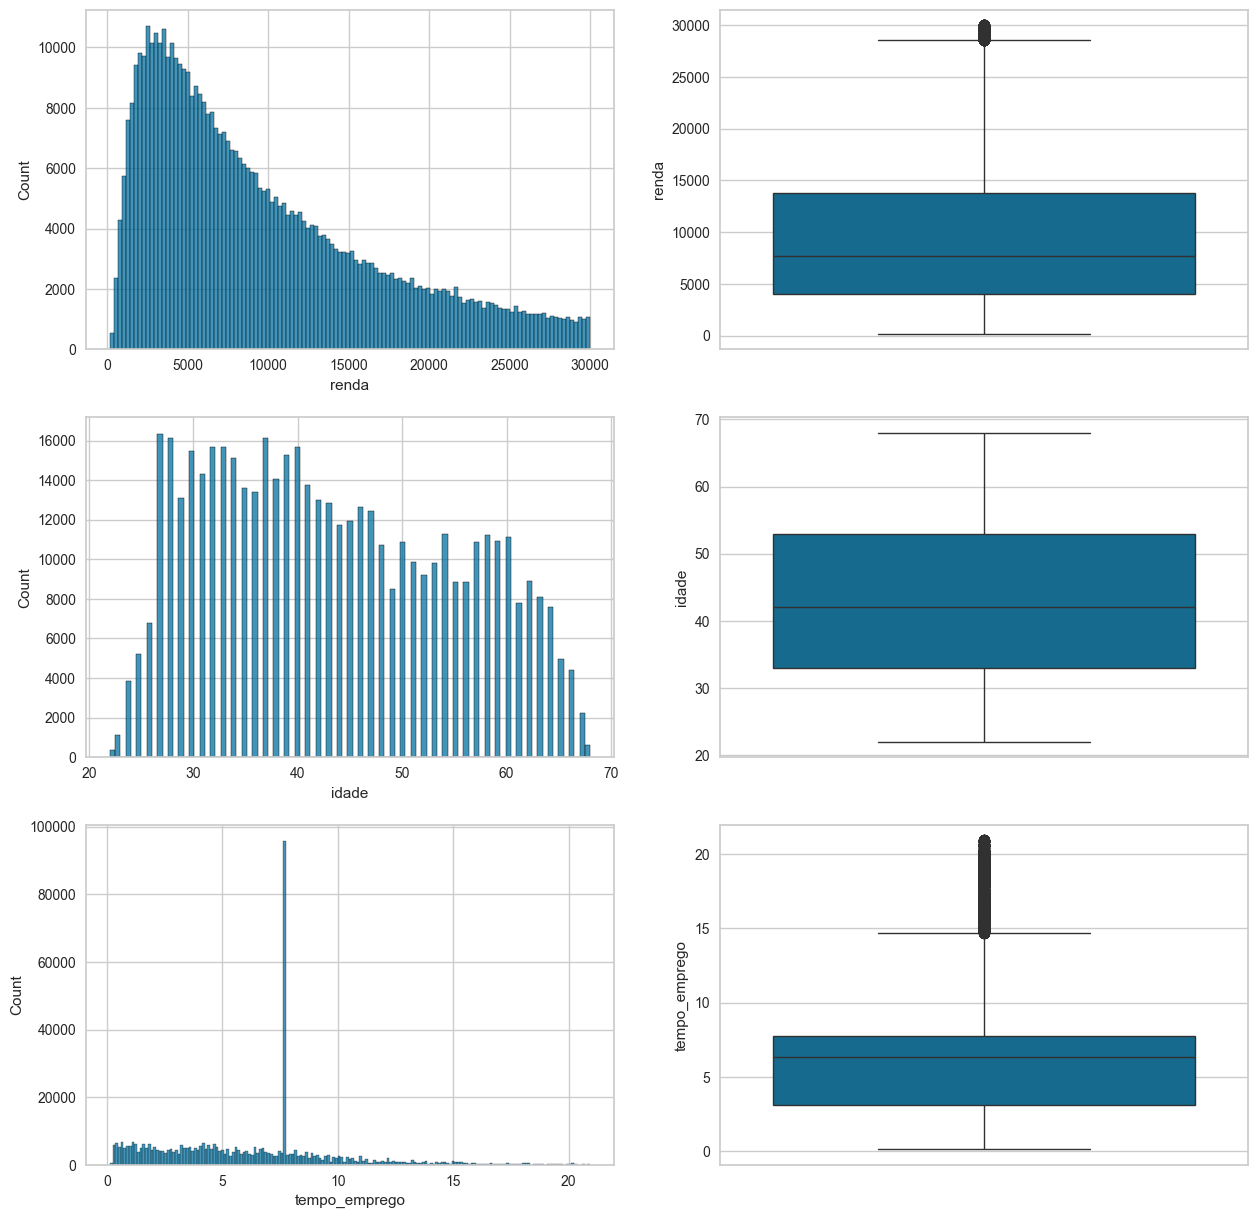

In [52]:
# Retorna a análise destas variáveis (média, mediana, contagem, etc)
print(desenvolvimento[quantitativas].describe())

# Gráfico boxplot e contagem de cada variável quantitativa
plt.rc('figure', figsize=(15, 15))
fig, axes = plt.subplots(3, 2)

# 'renda'
sns.histplot(x='renda', data=desenvolvimento, ax = axes[0,0])
sns.boxplot(y='renda', data=desenvolvimento, ax = axes[0,1])

# 'idade'
sns.histplot(x='idade', data=desenvolvimento, ax = axes[1,0])
sns.boxplot(y='idade', data=desenvolvimento, ax = axes[1,1])

# 'tempo_emprego'
sns.histplot(x='tempo_emprego', data=desenvolvimento, ax = axes[2,0])
sns.boxplot(y='tempo_emprego', data=desenvolvimento, ax = axes[2,1])

# Mostra o gráfico
plt.show()

### Tratamento de Zeros Estruturais e Agrupamento de Categorias

> Para resolver os zeros estruturais, as categorias que apresentam baixas quantidades em cada variável qualitativas serão combinadas em uma única. Em relação às variáveis quantitativas, cada uma delas será divida em 5 agrupamentos.

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,230593,19158,0.076708,Assalariado,249751,0.000533,0.077752,0.075665,-2.487934,-2.473288,-2.502764,0.056281,0.070927,0.041451
Bols./Serv.Pub./Pens.,120619,8675,0.067095,Bols./Serv.Pub./Pens.,129294,0.000696,0.068459,0.065731,-2.632191,-2.610607,-2.654187,-0.087977,-0.066393,-0.109972
Empresário,105134,8006,0.070762,Empresário,113140,0.000762,0.072256,0.069268,-2.575044,-2.552539,-2.597993,-0.030830,-0.008325,-0.053779


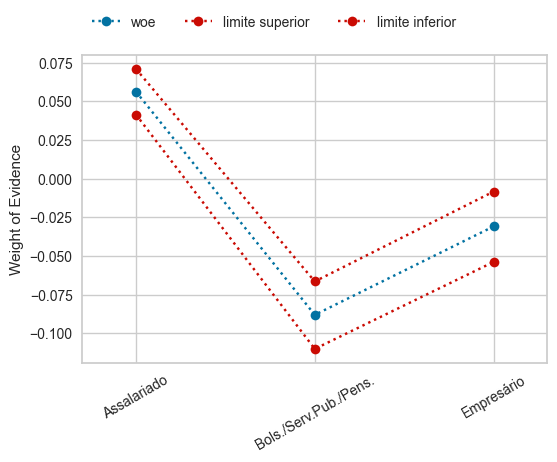

In [54]:
# Reagrupando a variável 'tipo_renda'
desenvolvimento.tipo_renda.replace({'Bolsista': 'Bols./Serv.Pub./Pens.', 
                                    'Servidor público': 'Bols./Serv.Pub./Pens.',
                                    'Pensionista': 'Bols./Serv.Pub./Pens.'}, 
                                   inplace=True)
biv_discreta('tipo_renda', desenvolvimento)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Acadêmico,141236,10395,0.068555,Acadêmico,151631,0.000649,0.069826,0.067283,-2.609107,-2.589358,-2.629199,-0.064893,-0.045143,-0.084985
Fundamental/Médio,315110,25444,0.074714,Fundamental/Médio,340554,0.000451,0.075597,0.073830,-2.516442,-2.503737,-2.529286,0.027773,0.040478,0.014929


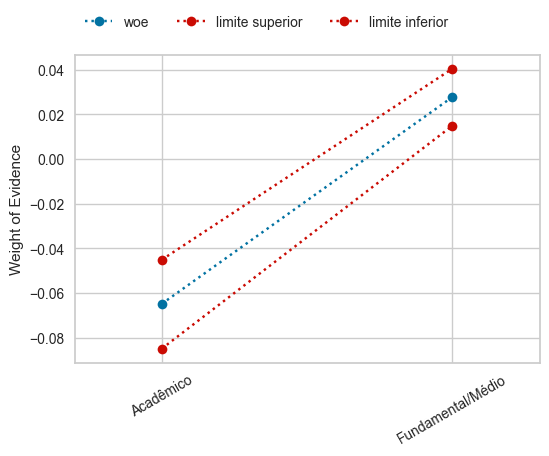

In [55]:
# Reagrupando a variável 'educacao'
desenvolvimento.educacao.replace({'Fundamental': 'Fundamental/Médio', 
                                  'Médio': 'Fundamental/Médio',
                                  'Superior incompleto': 'Acadêmico',
                                  'Superior completo': 'Acadêmico',
                                  'Pós graduação': 'Acadêmico'}, 
                                   inplace=True)
biv_discreta('educacao', desenvolvimento)

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,320911,24701,0.071470,Casado,345612,0.000438,0.072329,0.070611,-2.564320,-2.551450,-2.577334,-0.020105,-0.007235,-0.033120
Separado/Viúvo,44657,3605,0.074696,Separado/Viúvo,48262,0.001197,0.077042,0.072351,-2.516689,-2.483233,-2.551126,0.027525,0.060982,-0.006911
Solteiro,55774,4532,0.075150,Solteiro,60306,0.001074,0.077254,0.073046,-2.510144,-2.480252,-2.540816,0.034070,0.063962,0.003399
União,35004,3001,0.078963,União,38005,0.001383,0.081675,0.076252,-2.456517,-2.419808,-2.494397,0.087698,0.124407,0.049818


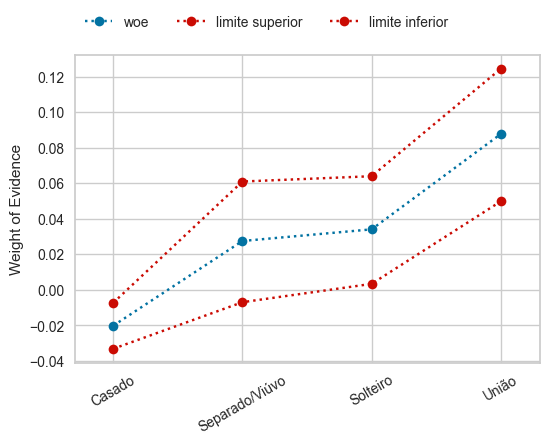

In [56]:
# Reagrupando a variável 'estado_civil'
desenvolvimento.estado_civil.replace({'Separado': 'Separado/Viúvo', 
                                      'Viúvo': 'Separado/Viúvo'}, 
                                      inplace=True)
biv_discreta('estado_civil', desenvolvimento)

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel/Estúdio,9734,810,0.076821,Aluguel/Estúdio,10544,0.002593,0.081905,0.071737,-2.486346,-2.416746,-2.560304,0.057869,0.127469,-0.016090
Casa,409032,31697,0.071919,Casa,440729,0.000389,0.072682,0.071157,-2.557571,-2.546199,-2.569055,-0.013357,-0.001985,-0.024840
Com os pais,21698,1971,0.083273,Com os pais,23669,0.001796,0.086794,0.079753,-2.398679,-2.353429,-2.445702,0.145536,0.190785,0.098512
Comun./Gov.,15882,1361,0.078931,Comun./Gov.,17243,0.002053,0.082955,0.074906,-2.456967,-2.402854,-2.513664,0.087248,0.141361,0.030551


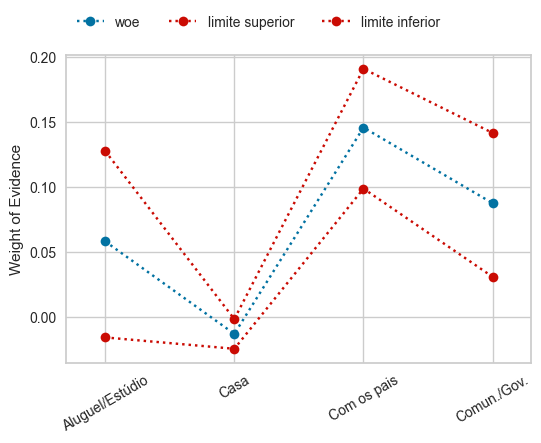

In [57]:
# Reagrupando a variável 'tipo_residencia'
desenvolvimento.tipo_residencia.replace({'Comunitário': 'Comun./Gov.',
                                         'Governamental': 'Comun./Gov.',
                                         'Aluguel': 'Aluguel/Estúdio',
                                         'Estúdio': 'Aluguel/Estúdio'},
                                         inplace=True)
biv_discreta('tipo_residencia', desenvolvimento)

### Primeiro Modelo de Regressão Logística

> Neste modelo inicial, será feita a regressão da variável 'mau' em função de todas as explicativas presentes na base de dados. A fórmula representativa será:
>
> $$ logit(mau) = \alpha_0 + \alpha_{1}x_1 + ... + \alpha_{n}x_{n}$$
>
> Com cada _x_ sendo uma variável explicativa e alpha, seu peso no ajuste.

In [59]:
# Variáveis presentes na base de desenvolvimento
' + '.join(list(metadados.sort_values(by='IV', ascending=False).index))

'renda + tempo_emprego + idade + tipo_renda + posse_de_imovel + educacao + tipo_residencia + sexo + estado_civil + qt_pessoas_residencia + posse_de_veiculo + qtd_filhos + mau'

In [60]:
# Fórmula da regressão logística
formula = ''' mau ~ renda + tempo_emprego + 
              idade + tipo_renda + posse_de_imovel + 
              educacao + tipo_residencia + sexo + 
              estado_civil + qt_pessoas_residencia + 
              posse_de_veiculo + qtd_filhos '''

# Ajuste da regressão logística
rl = smf.glm(formula, data=desenvolvimento, family=sm.families.Binomial()).fit()

# Mostra os resultados do ajuste
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               492185
Model:                                     GLM   Df Residuals:                   492167
Model Family:                         Binomial   Df Model:                           17
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.1808e+05
Date:                         Fri, 10 Jan 2025   Deviance:                   2.3616e+05
Time:                                 22:55:26   Pearson chi2:                 6.18e+05
No. Iterations:                              7   Pseudo R-squ. (CS):            0.04104
Covariance Type:                     nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               1.0403      0.186      5.589      0.000       0.675       1.405
tipo_renda[T.Bols./Serv.Pub./Pens.]     0.0192      0.017      1.151      0.250      -0.014       0.052
tipo_renda[T.Empresário]                0.0372      0.014      2.604      0.009       0.009       0.065
posse_de_imovel[T.S]                    0.0593      0.012      4.940      0.000       0.036       0.083
educacao[T.Fundamental/Médio]          -0.0388      0.013     -3.021      0.003      -0.064      -0.014
tipo_residencia[T.Casa]                 0.0918      0.038      2.405      0.016       0.017       0.167
tipo_residencia[T.Com os pais]          0.0761      0.045      1.706      0.088      -0.011       0.164
tipo_residencia[T.Comun./Gov.]          0.0893      0.047      1.882      0.060      -0.004       0.182
sexo[T.M]                               0.0858      0.013      6.412      0.000       0.060       0.112
estado_civil[T.Separado/Viúvo]          0.0973      0.092      1.058      0.290      -0.083       0.278
estado_civil[T.Solteiro]                0.1061      0.091      1.165      0.244      -0.072       0.285
estado_civil[T.União]                  -0.0463      0.021     -2.239      0.025      -0.087      -0.006
posse_de_veiculo[T.S]                  -0.0311      0.013     -2.470      0.013      -0.056      -0.006
renda                                   0.0002   1.43e-06    105.825      0.000       0.000       0.000
tempo_emprego                           0.0176      0.002      9.151      0.000       0.014       0.021
idade                                  -0.0003      0.001     -0.387      0.699      -0.002       0.001
qt_pessoas_residencia                   0.1061      0.090      1.179      0.238      -0.070       0.282
qtd_filhos                             -0.1095      0.090     -1.215      0.224      -0.286       0.067
=======================================================================================================
"""

> Analisando o p-value de cada variável, nota-se que as variáveis 'idade', 'qt_pessoas_residencia' e 'qtd_filhos' não influenciam no ajuste. Logo, vamos fazer uma nova regressão removendo-as.

In [62]:
# Fórmula da regressão logística
formula = ''' mau ~ renda + tempo_emprego + 
              tipo_renda + posse_de_imovel + 
              educacao + tipo_residencia + sexo + 
              estado_civil + posse_de_veiculo  '''

# Ajuste da regressão logística
rl = smf.glm(formula, data=desenvolvimento, family=sm.families.Binomial()).fit()

# Mostra os resultados do ajuste
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               492185
Model:                                     GLM   Df Residuals:                   492170
Model Family:                         Binomial   Df Model:                           14
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.1808e+05
Date:                         Fri, 10 Jan 2025   Deviance:                   2.3616e+05
Time:                                 22:55:43   Pearson chi2:                 6.18e+05
No. Iterations:                              7   Pseudo R-squ. (CS):            0.04103
Covariance Type:                     nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               1.2417      0.042     29.899      0.000       1.160       1.323
tipo_renda[T.Bols./Serv.Pub./Pens.]     0.0176      0.015      1.182      0.237      -0.012       0.047
tipo_renda[T.Empresário]                0.0374      0.014      2.622      0.009       0.009       0.065
posse_de_imovel[T.S]                    0.0588      0.012      4.929      0.000       0.035       0.082
educacao[T.Fundamental/Médio]          -0.0395      0.013     -3.142      0.002      -0.064      -0.015
tipo_residencia[T.Casa]                 0.0914      0.038      2.395      0.017       0.017       0.166
tipo_residencia[T.Com os pais]          0.0770      0.045      1.727      0.084      -0.010       0.164
tipo_residencia[T.Comun./Gov.]          0.0891      0.047      1.880      0.060      -0.004       0.182
sexo[T.M]                               0.0859      0.013      6.460      0.000       0.060       0.112
estado_civil[T.Separado/Viúvo]         -0.0092      0.019     -0.478      0.633      -0.047       0.029
estado_civil[T.Solteiro]                0.0024      0.017      0.140      0.889      -0.032       0.036
estado_civil[T.União]                  -0.0457      0.021     -2.217      0.027      -0.086      -0.005
posse_de_veiculo[T.S]                  -0.0311      0.013     -2.471      0.013      -0.056      -0.006
renda                                   0.0002   1.43e-06    105.847      0.000       0.000       0.000
tempo_emprego                           0.0175      0.002      9.169      0.000       0.014       0.021
=======================================================================================================
"""

> Nota-se que as variáveis 'estado_civil' e 'tipo_renda' têm categorias com p-value extremamente altos. Dessa forma, vamos removê-las do ajuste.

In [64]:
# Fórmula da regressão logística
formula = ''' mau ~ renda + tempo_emprego + 
              posse_de_imovel + 
              educacao + tipo_residencia + sexo + 
              posse_de_veiculo  '''

# Ajuste da regressão logística
rl = smf.glm(formula, data=desenvolvimento, family=sm.families.Binomial()).fit()

# Mostra os resultados do ajuste
rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               492185
Model:                                     GLM   Df Residuals:                   492175
Model Family:                         Binomial   Df Model:                            9
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.1809e+05
Date:                         Fri, 10 Jan 2025   Deviance:                   2.3618e+05
Time:                                 22:55:56   Pearson chi2:                 6.18e+05
No. Iterations:                              7   Pseudo R-squ. (CS):            0.04101
Covariance Type:                     nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          1.2503      0.041     30.746      0.000       1.171       1.330
posse_de_imovel[T.S]               0.0604      0.012      5.077      0.000       0.037       0.084
educacao[T.Fundamental/Médio]     -0.0436      0.012     -3.494      0.000      -0.068      -0.019
tipo_residencia[T.Casa]            0.0917      0.038      2.410      0.016       0.017       0.166
tipo_residencia[T.Com os pais]     0.0755      0.045      1.694      0.090      -0.012       0.163
tipo_residencia[T.Comun./Gov.]     0.0893      0.047      1.886      0.059      -0.003       0.182
sexo[T.M]                          0.0846      0.013      6.431      0.000       0.059       0.110
posse_de_veiculo[T.S]             -0.0305      0.012     -2.456      0.014      -0.055      -0.006
renda                              0.0002   1.43e-06    106.138      0.000       0.000       0.000
tempo_emprego                      0.0177      0.002      9.932      0.000       0.014       0.021
==================================================================================================
"""

> Apesar de algumas categorias da variável 'tipo_residencia' apresentarem p-value maior do que 5%, isso pode ser por semelhança à categoria tomada como referência no ajuste ao invés de prejudicá-lo em si. Dessa forma, a variável será mantida.

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

> Avaliando as métricas na base de desenvolvimento:

In [68]:
# Faz a predição da variável 'mau' na base de desenvolvimento pelo ajuste 
desenvolvimento['score'] = rl.predict(desenvolvimento)

# Acurácia
acc = metrics.accuracy_score(desenvolvimento.mau, 
                             desenvolvimento.score>.5)

#AUC
fpr, tpr, thresholds = metrics.roc_curve(desenvolvimento.mau, 
                                         desenvolvimento.score)
auc = metrics.auc(fpr, tpr)

#Gini
gini = 2*auc -1
ks = ks_2samp(desenvolvimento.loc[desenvolvimento.mau == 1, 'score'], 
              desenvolvimento.loc[desenvolvimento.mau != 1, 'score']).statistic

# Imprime os resultados
print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 7.3% 
AUC: 26.8% 
GINI: -46.5%
KS: 34.7%


> Avaliando as métricas na base Out-of-Time (antes, fazendo as alterações necessárias):

In [70]:
# Reagrupando a variável 'tipo_residencia'
oot.tipo_residencia.replace({'Comunitário': 'Comun./Gov.',
                             'Governamental': 'Comun./Gov.',
                             'Aluguel': 'Aluguel/Estúdio',
                             'Estúdio': 'Aluguel/Estúdio'},
                             inplace=True)

# Reagrupando a variável 'educacao'
oot.educacao.replace({'Fundamental': 'Fundamental/Médio', 
                      'Médio': 'Fundamental/Médio',
                      'Superior incompleto': 'Acadêmico',
                      'Superior completo': 'Acadêmico',
                      'Pós graduação': 'Acadêmico'}, 
                      inplace=True)

# Remove as missing da base oot
oot.dropna(inplace=True)

In [71]:
# Faz a predição da variável 'mau' na base de desenvolvimento pelo ajuste 
oot['score'] = rl.predict(oot)

# Acurácia
acc = metrics.accuracy_score(oot.mau, 
                             oot.score>.5)

#AUC
fpr, tpr, thresholds = metrics.roc_curve(oot.mau, 
                                         oot.score)
auc = metrics.auc(fpr, tpr)

#Gini
gini = 2*auc -1
ks = ks_2samp(oot.loc[oot.mau == 1, 'score'], 
              oot.loc[oot.mau != 1, 'score']).statistic

# Imprime os resultados
print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 14.5% 
AUC: 25.6% 
GINI: -48.7%
KS: 36.0%


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

In [74]:
# Carregando os dados
df = pd.read_feather('credit_scoring.ftr')

# Remove as colunas 'index' e 'data_ref'
df.drop(columns=['data_ref','index'], inplace=True)

# Mostra os tipos de variáveis na base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   750000 non-null  object 
 1   posse_de_veiculo       750000 non-null  object 
 2   posse_de_imovel        750000 non-null  object 
 3   qtd_filhos             750000 non-null  int64  
 4   tipo_renda             750000 non-null  object 
 5   educacao               750000 non-null  object 
 6   estado_civil           750000 non-null  object 
 7   tipo_residencia        750000 non-null  object 
 8   idade                  750000 non-null  int64  
 9   tempo_emprego          624043 non-null  float64
 10  qt_pessoas_residencia  750000 non-null  float64
 11  renda                  750000 non-null  float64
 12  mau                    750000 non-null  bool   
dtypes: bool(1), float64(3), int64(2), object(7)
memory usage: 69.4+ MB


In [75]:
# Faz uma cópia do dataframe para a pipeline
df2 = df.copy()

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [77]:
# Verifica se há nulos na base
df.isna().sum()

sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

> Há valores nulos apenas na variável 'tempo_emprego', que é quantitativa (_Dtype = float64_). Logo, os nulos serão substituídos pela média.

In [79]:
# Insere a média dos valores nos nulos
df.tempo_emprego.fillna(df.tempo_emprego.mean(), inplace=True)

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

> Para identificar outliers, será usada a função 'remove_outliers' desenvolvida em aula, que seleciona apenas os dados no intervalo aceito do boxplot da variável.

In [82]:
# Função 'remove_outliers' desenvolvida em aula
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

> Dado que apenas as variáveis numéricas apresentam outliers, vamos separar as que são quantitativas das que são qualitativas do dataframe.

In [84]:
# Listas com as variáveis qualitativas e quantitativas da base
qualitativas = df.select_dtypes(include=['object']).columns
quantitativas = df.select_dtypes(include=['int64', 'float64']).columns

In [85]:
# Aplica a função 'remove_outliers' na base
for quantitativa in quantitativas:
    df = remove_outliers(df, quantitativa)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [87]:
# Aplica o get_dummies() sobre o df
df = pd.get_dummies(df, drop_first=True).astype(int)

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

> Será usada a técnica Feaure importance. Para isso, será realizada uma regressão logística inicial sobre toda a base. 

<Axes: ylabel='Feature'>

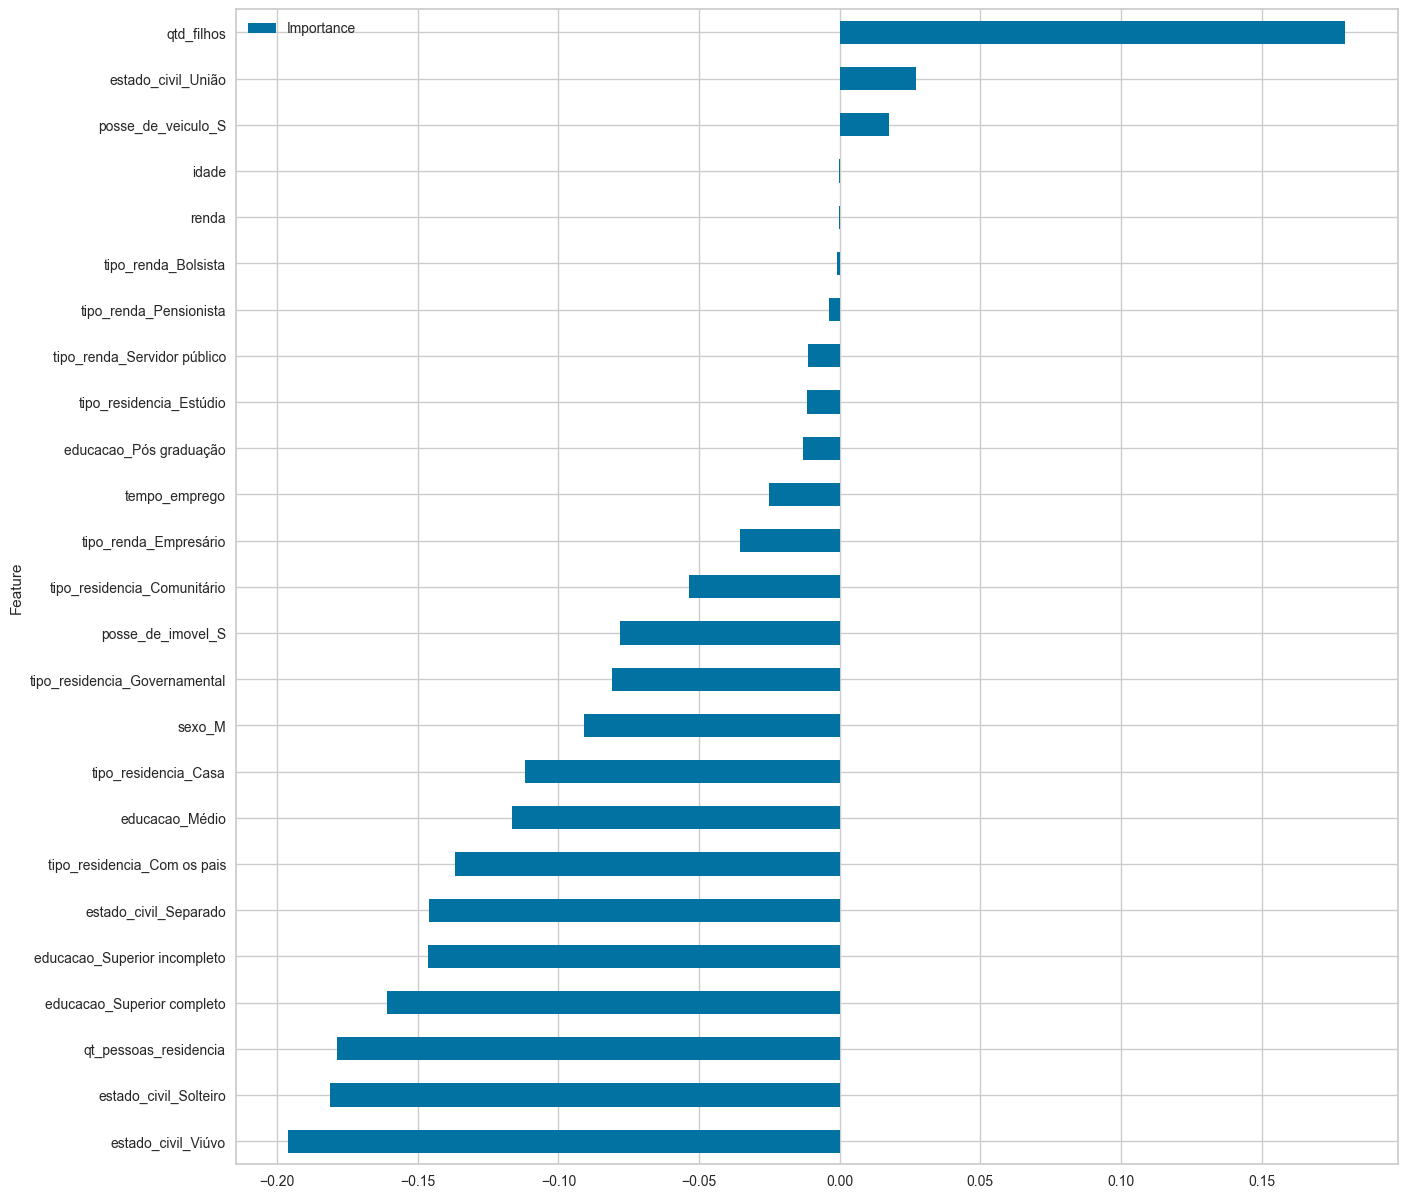

In [90]:
# Separa a variável resposta das explicativas
y = df.mau
X = df.drop(columns='mau')

# Realiza a regressão logística no dataframe
logistic = LogisticRegression(max_iter=1000)
logistic.fit(X, y)

# Faz o gráfico da feature importance
feature = pd.DataFrame({'Feature': X.columns, 'Importance': logistic.coef_[0]})
feature = feature.sort_values('Importance', ascending=True)
feature.plot(x='Feature', y='Importance', kind='barh')

> Serão selecionadas apenas as variáveis cuja importância é maior do que -0.10.

In [92]:
# Lista com as variáveis que têm importância maior do que -0.1
variaveis = (feature.reset_index().
             Feature[feature.Importance > -0.1])

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [94]:
# Normaliza as variáveis explicativas
scaler = StandardScaler() 
scaler.fit(X)
X = scaler.transform(X)

# Aplica PCA para reduzir a dimensionalidade para 5
pca = PCA(n_components=5)
pca.fit(X)
X = pca.transform(X)

In [95]:
# Mostra o df resultante do PCA
df_prep = pd.DataFrame(data=X, columns=[f'PC{i}' for i in range(1,6)])
df_prep

,PC1,PC2,PC3,PC4,PC5
0,-1.016613,1.550682,0.354825,-2.409289,0.042757
1,-0.128844,-0.397791,-0.549450,-1.065170,0.211559
2,2.037252,-1.330022,-1.890992,-0.497007,-2.122665
3,-1.423706,-0.258338,-0.590053,0.838535,0.270176
4,0.418653,1.816349,1.851281,-1.852600,0.202234
...,...,...,...,...,...
625128,0.765853,0.078012,2.030232,-0.894266,-0.157943
625129,-3.445849,0.724848,0.366183,-0.713166,-0.054136
625130,2.029187,-1.935118,-2.048237,0.662388,0.480048
625131,-3.270525,-0.106357,-0.073976,0.814265,-0.530255


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [97]:
# Separa as colunas numéricas das qualitativas do dataframe
quantitativas = df2.select_dtypes(include=['int64', 'float64']).columns
qualitativas = df2.select_dtypes(include=['object']).columns


# Pipeline que corrige as numéricas
numericas = Pipeline(steps=[
         ('nulos', SimpleImputer(strategy='mean')),
         ('outliers', RobustScaler())
])

# Pipeline que converte as categoricas em dummies
categoricas = Pipeline(steps=[
         ('nulos', SimpleImputer(strategy='most_frequent')),
         ('dummies', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Corrige todas as variáveis 
conversor = ColumnTransformer([
    ('num', numericas, quantitativas),
    ('cat', categoricas, qualitativas)
])

# Faz todo o preprocessamento 
preprocessamento = Pipeline(steps=[
    ('conversor', conversor),
    ('pca', PCA(n_components=5))
])

In [98]:
# Separando o df2 em treino e teste
X = df2.drop(columns='mau')
y = df2.mau.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [99]:
# Ajustando o pipeline na base de treino
preprocessamento.fit(X_train, y_train)

Pipeline(steps=[('conversor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('nulos',
                                                                   SimpleImputer()),
                                                                  ('outliers',
                                                                   RobustScaler())]),
                                                  Index(['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('nulos',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('dummies',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia'],
      dtype='object'))])),
                ('pca', PCA(n_components=5))])

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



### Carregando os dados

In [102]:
# Salva os dados na variável 'df'
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [103]:
# Mostra as quantidades de linhas e variáveis no dataframe
print('Número de linhas: ', df.shape[0], '\nNúmero de colunas: ', df.shape[1])

Número de linhas:  750000 
Número de colunas:  15


In [104]:
# Mostra as colunas no dataframe
df.columns

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')

In [105]:
# Separa 50000 linhas do dataframe
dataset = df.sample(50000)

In [106]:
# Remove as colunas 'data_ref' e 'index' do dataset
dataset.drop(['data_ref', 'index'], axis=1, inplace=True)

In [107]:
# Divide os dados escolhidos em treino, teste e validação
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


### Configurando o pycaret

In [109]:
# Mostra as informações dos dados separados
exp_clf = setup(data=data, target='mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.8%


### Criando um modelo lightGBM

In [111]:
# Mostra os modelos de ajuste do pacote pycaret.classification
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [112]:
# Faz um modelo lightgbm
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9221,0.5030,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9221,0.5188,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9218,0.4749,0.0000,0.0000,0.0000,-0.0006,-0.0050
3,0.9221,0.4965,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.9215,0.4756,0.0000,0.0000,0.0000,-0.0006,-0.0051
5,0.9218,0.5089,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.9218,0.5146,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.9218,0.4906,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.9218,0.5217,0.0000,0.0000,0.0000,0.0000,0.0000


In [113]:
# Aperfeiçoa o modelo a partir da precisão
tuned_lightgbm = tune_model(lightgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9125,0.5263,0.0077,0.0556,0.0136,-0.0056,-0.0087
1,0.9155,0.5122,0.0039,0.0417,0.0071,-0.0062,-0.0115
2,0.9113,0.4669,0.0116,0.0714,0.0199,-0.0018,-0.0027
3,0.9143,0.5176,0.0039,0.0357,0.0070,-0.0084,-0.0145
4,0.9110,0.5274,0.0000,0.0000,0.0000,-0.0194,-0.0305
5,0.9173,0.4995,0.0154,0.1739,0.0283,0.0158,0.0298
6,0.9140,0.4792,0.0192,0.1389,0.0338,0.0150,0.0237
7,0.9158,0.4906,0.0115,0.1154,0.0210,0.0069,0.0123
8,0.9155,0.5340,0.0269,0.2000,0.0475,0.0294,0.0468


Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Analisando o resultado do modelo

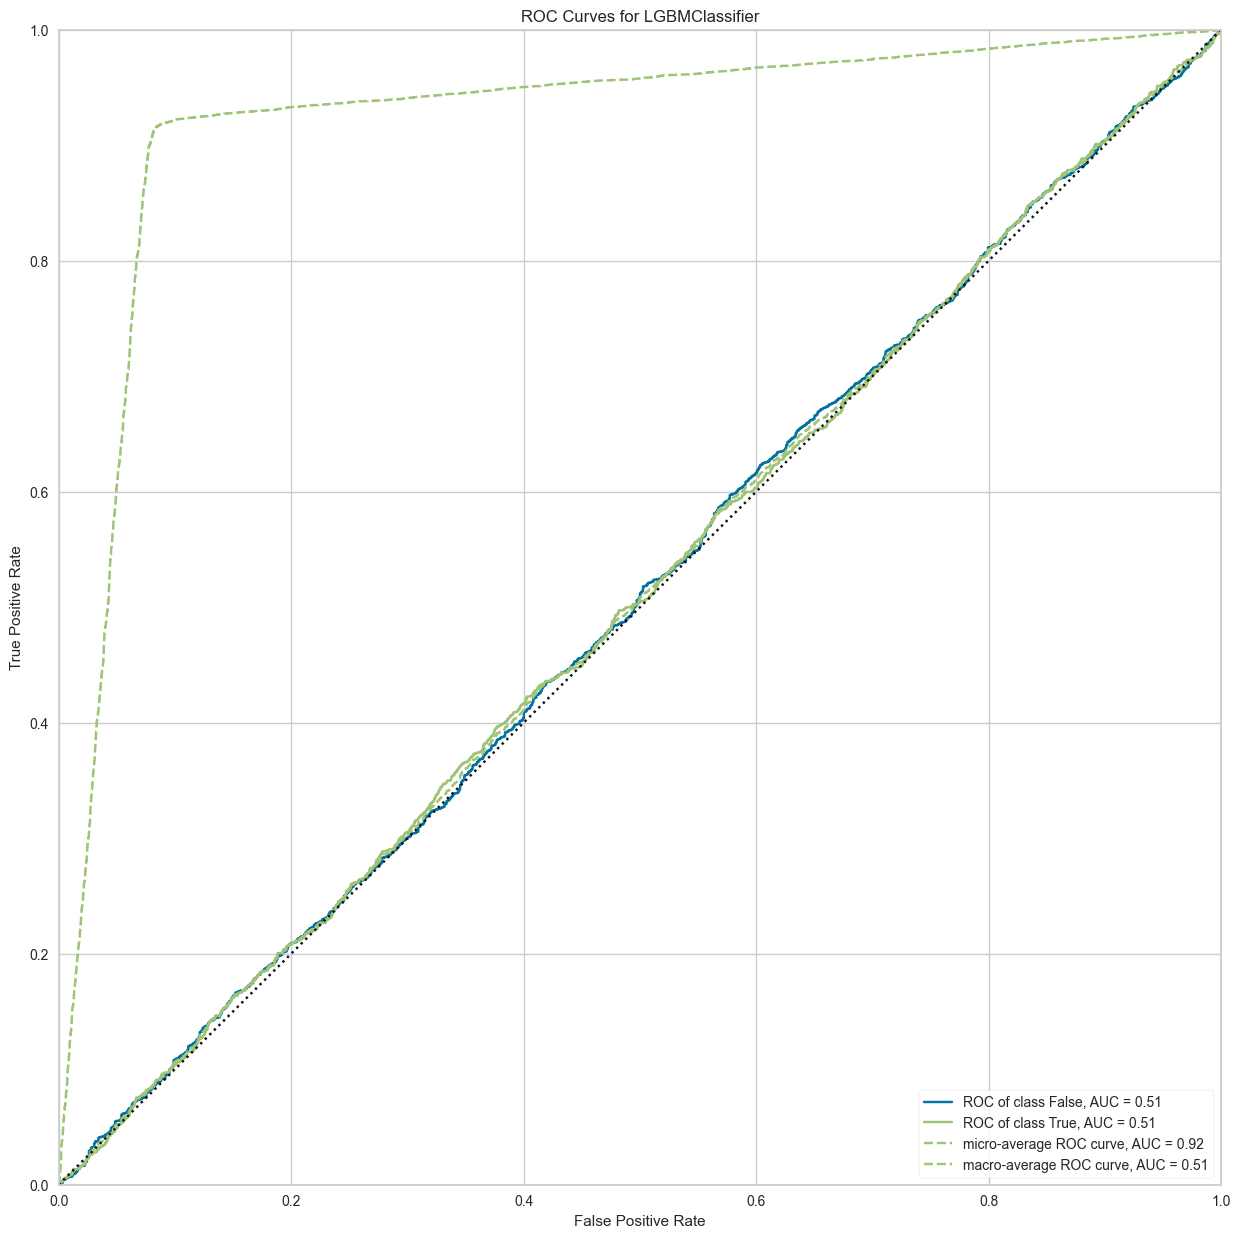

In [115]:
# Gráfico AUC
plot_model(tuned_lightgbm, plot = 'auc')

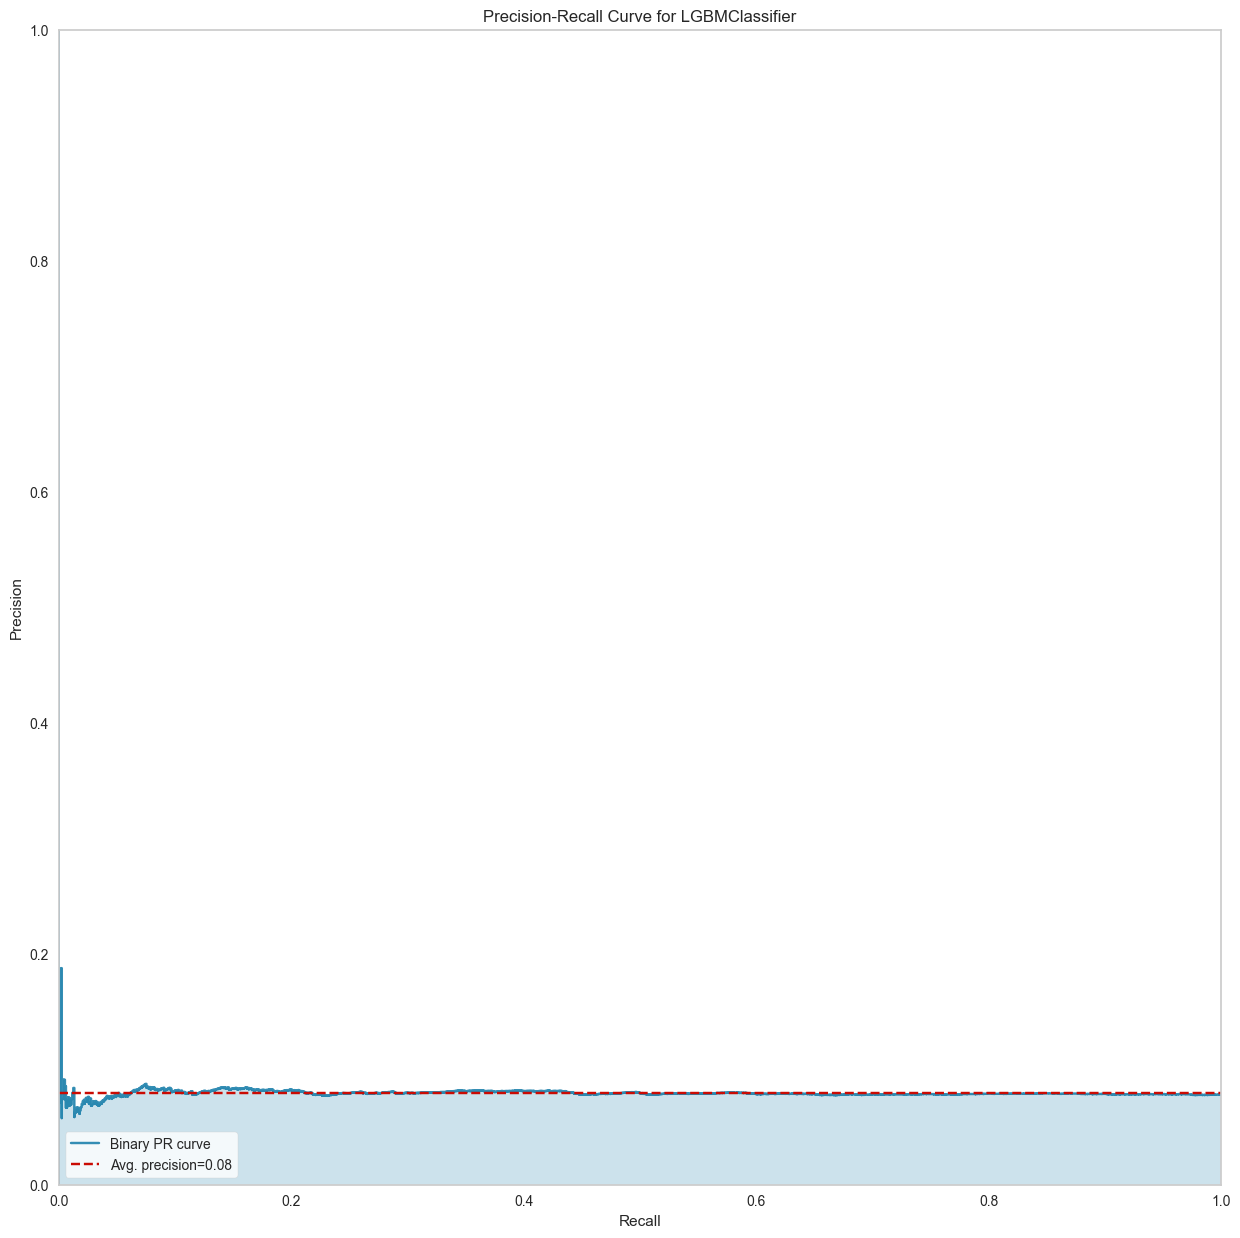

In [116]:
# Gráfico de Precisão
plot_model(tuned_lightgbm, plot = 'pr')

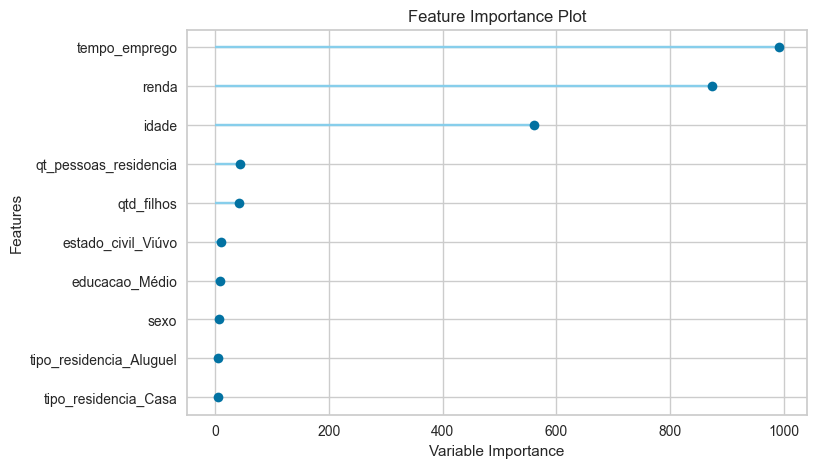

In [117]:
# Importância das Variáveis
plot_model(tuned_lightgbm, plot='feature')

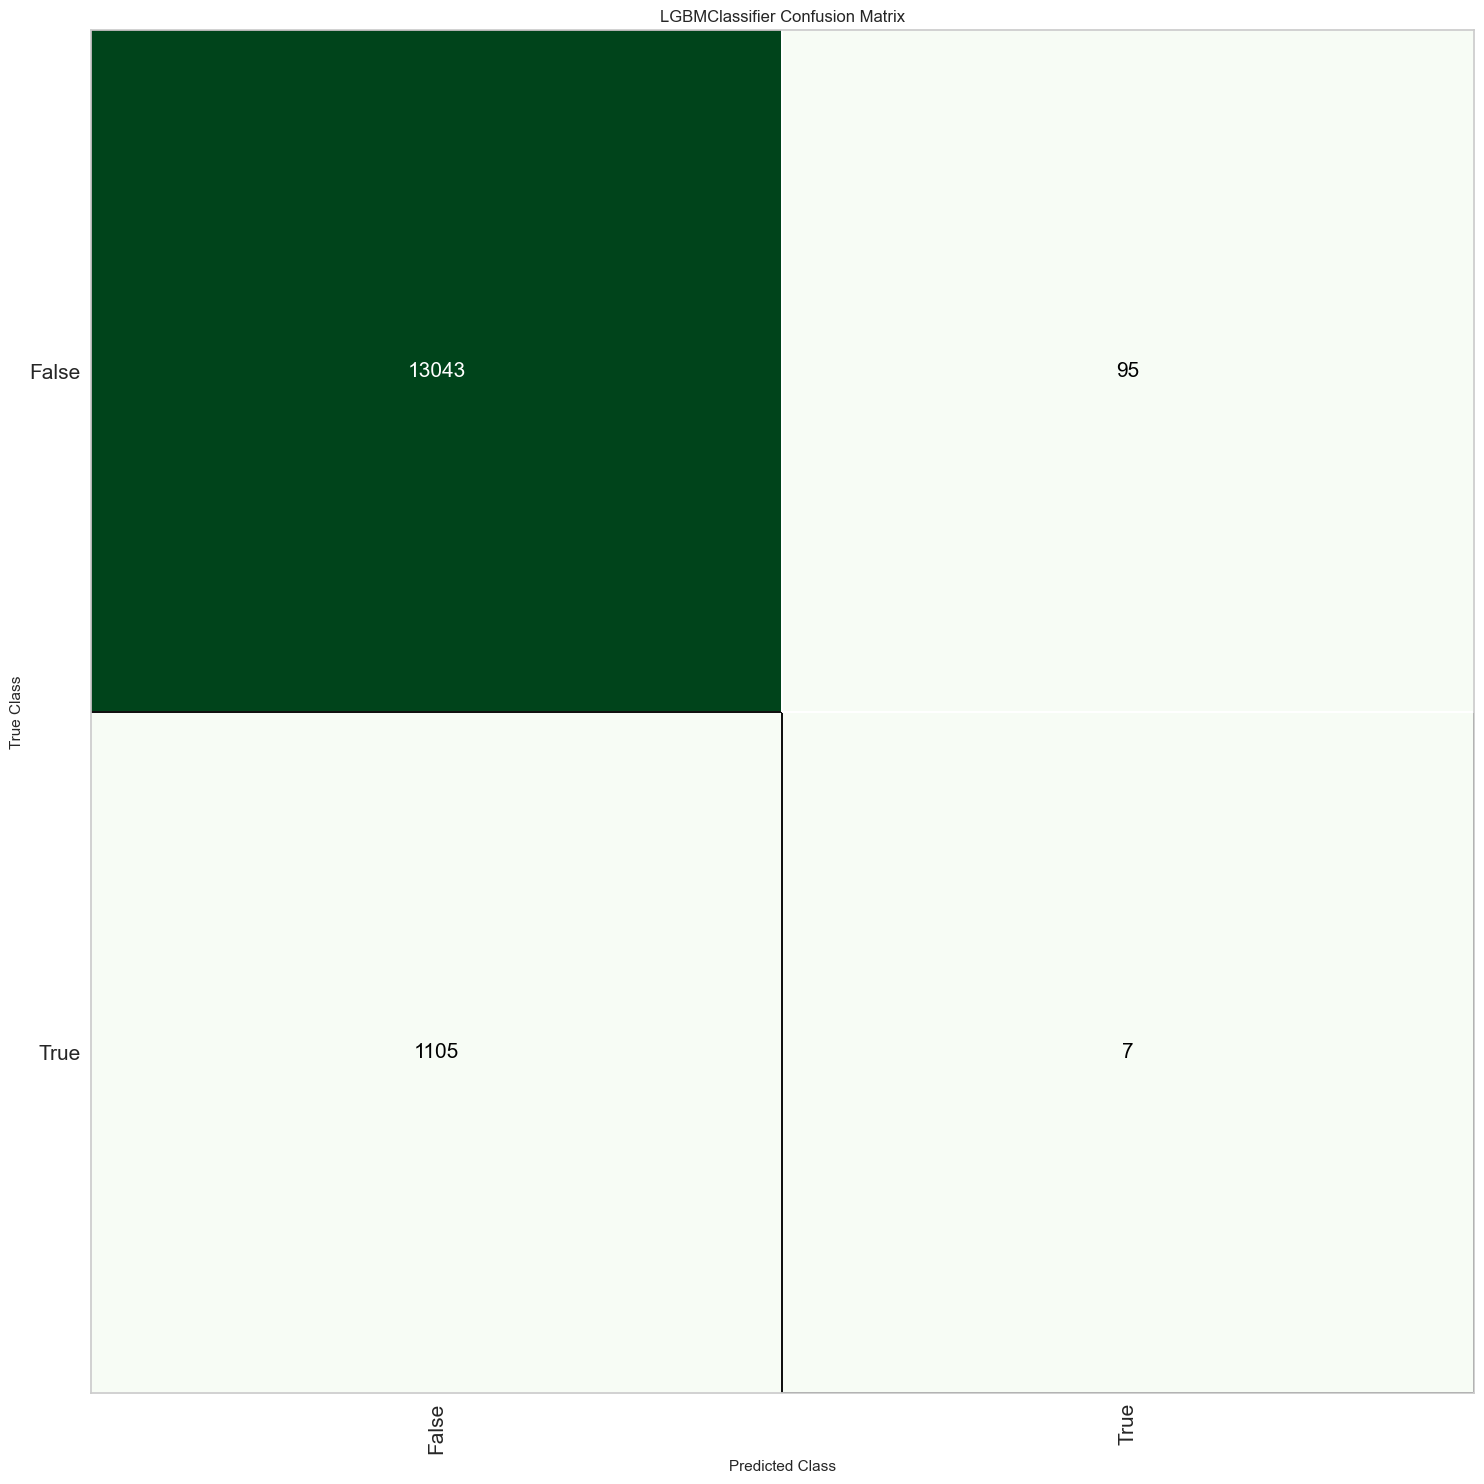

In [118]:
# Matriz de Confusão
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

In [119]:
# Gráficos e informações do ajuste aperfeiçoado
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Predict na amostra de validação

In [121]:
# Predição na amostra de validação
predict_model(tuned_lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9158,0.5059,0.0063,0.0686,0.0115,-0.0016,-0.0030


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


### Finalizando o modelo para deploy

In [123]:
# Finaliza o modelo
final_lgbm = finalize_model(tuned_lightgbm)

In [124]:
#Parâmetros finais do modelo LightGBM para deploy
print(final_lgbm)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                boosting_type='gbdt', class_weight=None,
                           

In [125]:
# Faz uma predição com o modelo finalizado
predict_model(final_lgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9111,0.4983,0.0135,0.0811,0.0231,0.0009,0.0013


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


### Predizendo o conjunto de dados que não foi usado no treino

In [127]:
# Aplica o modelo nos dados de validação
unseen_predictions = predict_model(final_lgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9024,0.5065,0.0045,0.0385,0.0081,-0.0107,-0.0179


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,N,S,0,Pensionista,Médio,União,Casa,57,NaN,2.0,10095.129883,False,0,0.9295
1,F,N,S,0,Assalariado,Médio,Casado,Casa,46,15.726027,2.0,12290.969727,False,0,0.9663
2,F,N,N,0,Assalariado,Médio,Casado,Casa,51,8.638356,2.0,4351.419922,False,0,0.9549
3,M,S,S,0,Assalariado,Médio,Casado,Casa,33,3.090411,2.0,11166.719727,False,1,0.6423
4,M,N,S,0,Assalariado,Médio,Solteiro,Casa,56,3.219178,1.0,18886.169922,False,0,0.9582


### Salvando o modelo final

In [129]:
# Salva o modelo
save_model(final_lgbm,'Final GBC Model 09Jan2025')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            